# Object Classification with YOLOv8

This notebook demonstrates training a YOLOv8 model for object classification, specifically for car detection with multiple classes. It covers data loading, model training, evaluation, and inference.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# === PATH DEFINITIONS ===
import os # Import os here as it's used immediately

DRIVE_MOUNT_POINT = '/content/drive'
BASE_PROJECT_PATH = '/content/drive/MyDrive/Projects/Car Detection v2/'
DATASET_BASE_PATH = os.path.join(BASE_PROJECT_PATH, 'Single Class Data')

# Training data paths
TRAIN_IMAGES_PATH = os.path.join(DATASET_BASE_PATH, 'train/images/')
TRAIN_LABELS_PATH = os.path.join(DATASET_BASE_PATH, 'train/labels/')

# Validation data paths
VALID_IMAGES_PATH = os.path.join(DATASET_BASE_PATH, 'valid/images/')
VALID_LABELS_PATH = os.path.join(DATASET_BASE_PATH, 'valid/labels/')

# Test data path
TEST_IMAGES_DIR = os.path.join(DATASET_BASE_PATH, 'test/images')

# Dataset configuration file
DATASET_YAML_PATH = os.path.join(DATASET_BASE_PATH, 'data.yaml')

# Model training output paths
MODEL_OUTPUT_BASE_PATH = os.path.join(BASE_PROJECT_PATH, 'Colab Env/Model History')
EXPERIMENT_NAME = 'singleclass_colab_YOLOv8' # Choose a descriptive name
FULL_EXPERIMENT_PATH = os.path.join(MODEL_OUTPUT_BASE_PATH, EXPERIMENT_NAME)

# Paths to specific files generated during training
BEST_WEIGHTS_PATH = os.path.join(FULL_EXPERIMENT_PATH, 'weights/best.pt')
RESULTS_CSV_PATH = os.path.join(FULL_EXPERIMENT_PATH, 'results.csv')
CONFUSION_MATRIX_IMG_PATH = os.path.join(FULL_EXPERIMENT_PATH, 'confusion_matrix.png')

# Paths to video test
VIDEO_TEST = os.path.join(BASE_PROJECT_PATH, 'Video Test')
VIDEO_TEST_PREDICTION = os.path.join(BASE_PROJECT_PATH, 'Video Test Prediction Colab Env')

print(f"Base Project Path: {BASE_PROJECT_PATH}")
print(f"Dataset Path: {DATASET_BASE_PATH}")
print(f"Dataset YAML Path: {DATASET_YAML_PATH}")
print(f"Model Output Path: {FULL_EXPERIMENT_PATH}")
print(f"Best Weights will be saved to: {BEST_WEIGHTS_PATH}")

Base Project Path: /content/drive/MyDrive/Projects/Car Detection v2/
Dataset Path: /content/drive/MyDrive/Projects/Car Detection v2/Single Class Data
Dataset YAML Path: /content/drive/MyDrive/Projects/Car Detection v2/Single Class Data/data.yaml
Model Output Path: /content/drive/MyDrive/Projects/Car Detection v2/Colab Env/Model History/singleclass_colab_YOLOv8
Best Weights will be saved to: /content/drive/MyDrive/Projects/Car Detection v2/Colab Env/Model History/singleclass_colab_YOLOv8/weights/best.pt


## 1. Install Dependencies & Import Libraries

In [ ]:
# === Installations (if not already installed in your environment) ===
!pip install ultralytics matplotlib seaborn pandas squarify opencv-python

# === System & I/O ===
import random
import glob

# === Data & Visualization ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import matplotlib.image as mpimg

# === Computer Vision & Model ===
import cv2
from ultralytics import YOLO

# Configure plotting style for seaborn and matplotlib
sns.set_style('darkgrid')
%matplotlib inline

## 2. Dataset Verification & Exploration
Verify that the dataset paths are correct and explore some sample images.

In [ ]:
# Verify dataset directory
if os.path.exists(DATASET_BASE_PATH):
    print(f"Dataset directory listing for: {DATASET_BASE_PATH}")
    print(os.listdir(DATASET_BASE_PATH))
else:
    print(f"ERROR: Dataset base path not found: {DATASET_BASE_PATH}")

if os.path.exists(TRAIN_IMAGES_PATH):
    print(f"\nTrain images directory listing for: {TRAIN_IMAGES_PATH}")
else:
    print(f"ERROR: Train images path not found: {TRAIN_IMAGES_PATH}")

Dataset directory listing for: /content/drive/MyDrive/Projects/Car Detection v2/Single Class Data
['README.dataset.txt', 'data.yaml', 'README.roboflow.txt', '.DS_Store', 'valid', 'test', 'train']

Train images directory listing for: /content/drive/MyDrive/Projects/Car Detection v2/Single Class Data/train/images/


In [ ]:
# Count number of training images
if os.path.exists(TRAIN_IMAGES_PATH):
    train_image_files_list = os.listdir(TRAIN_IMAGES_PATH)
    number_train_files = len(train_image_files_list)
    print(f"Number of training images: {number_train_files}")
else:
    print(f"Cannot count training images, path not found: {TRAIN_IMAGES_PATH}")
    number_train_files = 0

Number of training images: 1467


In [ ]:
# Show 16 random annotated training images
if number_train_files >= 16:
    sample_files = random.sample(train_image_files_list, 16)
    fig, axs = plt.subplots(4, 4, figsize=(16, 16))
    fig.suptitle('Sample Annotated Training Images', fontsize=20)

    for i, fname in enumerate(sample_files):
        img_path = os.path.join(TRAIN_IMAGES_PATH, fname)
        label_fname = os.path.splitext(fname)[0] + '.txt'
        label_path = os.path.join(TRAIN_LABELS_PATH, label_fname)

        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Could not read image {img_path}")
            continue

        # Read and draw each bounding box
        if os.path.exists(label_path):
            with open(label_path) as f:
                for line in f.read().splitlines():
                    try:
                        cls, x_c, y_c, w, h = map(float, line.split())
                        x1 = int((x_c - w / 2) * img.shape[1])
                        y1 = int((y_c - h / 2) * img.shape[0])
                        x2 = int((x_c + w / 2) * img.shape[1])
                        y2 = int((y_c + h / 2) * img.shape[0])
                        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    except ValueError:
                        print(f"Warning: Malformed label in {label_path}: {line}")
        else:
            print(f"Warning: Label file not found for {fname} at {label_path}")


        ax = axs[i // 4, i % 4]
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(fname, fontsize=8)
        ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
elif number_train_files > 0:
    print(f"Not enough training images to display 16 samples. Found {number_train_files}.")
else:
    print("No training images found to display.")

Output hidden; open in https://colab.research.google.com to view.

## 3. YOLOv8 Model Training
Initialize the YOLOv8 model and start the training process.

In [ ]:
# Initialize YOLOv8 Model
# You can choose different pre-trained models: yolov8n.pt, yolov8s.pt, yolov8m.pt, yolov8l.pt, yolov8x.pt
# yolov8x.pt is larger and more accurate but slower. yolov8n.pt is the smallest and fastest.
model = YOLO('yolov8x.pt') # Load pre-trained weights

IMG_HEIGHT = 300 # Define image height/size for training

# Train configuration
# Ensure DATASET_YAML_PATH is correctly pointing to your data.yaml file.
if os.path.exists(DATASET_YAML_PATH):
    print(f"Starting training with configuration file: {DATASET_YAML_PATH}")
    results = model.train(
        data=DATASET_YAML_PATH,
        epochs=50,                         # Number of training epochs
        imgsz=IMG_HEIGHT,                 # Image size for training
        seed=42,                          # For reproducibility
        batch=16,                         # Batch size (adjust based on your GPU memory)
        workers=8,                        # Number of worker threads for data loading (adjust based on your CPU)
        project=MODEL_OUTPUT_BASE_PATH,   # Base directory to save results
        name=EXPERIMENT_NAME,             # Subdirectory for this specific run
        exist_ok=True,                    # Overwrite previous run if 'name' directory exists
    )
    print(f"Training complete. Results saved in: {FULL_EXPERIMENT_PATH}")
else:
    print(f"ERROR: Dataset YAML file not found at {DATASET_YAML_PATH}. Cannot start training.")
    results = None # Ensure 'results' is defined even if training doesn't run

Starting training with configuration file: /content/drive/MyDrive/Projects/Car Detection v2/Single Class Data/data.yaml
Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Projects/Car Detection v2/Single Class Data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=300, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8x.pt, momentum=0.937, mosaic=1.0, multi_scal

train: Scanning /content/drive/MyDrive/Projects/Car Detection v2/Single Class Data/train/labels.cache... 1467 images, 107 backgrounds, 0 corrupt: 100%|██████████| 1467/1467 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 2.0±2.7 ms, read: 10.9±2.6 MB/s, size: 67.3 KB)


val: Scanning /content/drive/MyDrive/Projects/Car Detection v2/Single Class Data/valid/labels.cache... 233 images, 14 backgrounds, 0 corrupt: 100%|██████████| 233/233 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/Projects/Car Detection v2/Colab Env/Model History/singleclass_colab_YOLOv8/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/Projects/Car Detection v2/Colab Env/Model History/singleclass_colab_YOLOv8
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      12.2G      1.748      1.246      1.451        105        320: 100%|██████████| 92/92 [00:34<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.04it/s]

                   all        233       1686      0.241      0.555      0.186     0.0818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.12G      1.743      1.031      1.437         90        320: 100%|██████████| 92/92 [00:33<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.14it/s]

                   all        233       1686       0.64      0.532      0.565      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.54G      1.746      1.031      1.451         96        320: 100%|██████████| 92/92 [00:35<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.06it/s]

                   all        233       1686      0.639      0.632      0.601      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.99G      1.693      0.946      1.412        111        320: 100%|██████████| 92/92 [00:35<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.00it/s]

                   all        233       1686       0.25      0.666      0.215        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.39G      1.618     0.8833      1.371        121        320: 100%|██████████| 92/92 [00:33<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.16it/s]

                   all        233       1686      0.646      0.665      0.646      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.76G      1.596     0.8703      1.359         92        320: 100%|██████████| 92/92 [00:33<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.22it/s]

                   all        233       1686       0.74      0.678      0.705      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.76G      1.533      0.833      1.324        183        320: 100%|██████████| 92/92 [00:33<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.22it/s]

                   all        233       1686       0.84      0.768      0.827      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.76G      1.524     0.8166      1.326         80        320: 100%|██████████| 92/92 [00:35<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.08it/s]

                   all        233       1686      0.744      0.671      0.723      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.76G      1.501     0.7856      1.305        118        320: 100%|██████████| 92/92 [00:33<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.22it/s]

                   all        233       1686      0.822      0.762      0.816      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.76G      1.473     0.7828      1.292        100        320: 100%|██████████| 92/92 [00:33<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.22it/s]

                   all        233       1686      0.822      0.776      0.826      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.76G       1.43     0.7511      1.264         94        320: 100%|██████████| 92/92 [00:32<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.19it/s]

                   all        233       1686      0.831      0.817       0.87      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.76G      1.409     0.7313      1.245        196        320: 100%|██████████| 92/92 [00:35<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.10it/s]

                   all        233       1686      0.826      0.783      0.841      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.76G      1.394     0.7157      1.236        101        320: 100%|██████████| 92/92 [00:33<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.23it/s]

                   all        233       1686      0.831      0.796      0.849      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.76G      1.374      0.718      1.236        110        320: 100%|██████████| 92/92 [00:33<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.24it/s]

                   all        233       1686      0.833      0.803      0.853      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.76G      1.386     0.7141      1.226        157        320: 100%|██████████| 92/92 [00:33<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.22it/s]

                   all        233       1686      0.837      0.763      0.833      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.76G      1.369     0.7029      1.224         66        320: 100%|██████████| 92/92 [00:33<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.24it/s]

                   all        233       1686      0.818      0.846      0.866        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.76G       1.31      0.675      1.186        157        320: 100%|██████████| 92/92 [00:35<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.03it/s]

                   all        233       1686      0.839      0.844      0.889      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.76G      1.328     0.6686      1.202        107        320: 100%|██████████| 92/92 [00:35<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.15it/s]

                   all        233       1686      0.864      0.803      0.869      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.76G      1.295     0.6646       1.19        120        320: 100%|██████████| 92/92 [00:33<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.22it/s]

                   all        233       1686      0.866      0.822      0.884      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.76G      1.279     0.6421       1.18        168        320: 100%|██████████| 92/92 [00:33<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.19it/s]

                   all        233       1686      0.827      0.853      0.882      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.76G      1.276      0.647      1.184         85        320: 100%|██████████| 92/92 [00:33<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.23it/s]

                   all        233       1686      0.859       0.81      0.876      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.76G      1.228     0.6091      1.157         54        320: 100%|██████████| 92/92 [00:33<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.24it/s]

                   all        233       1686      0.861      0.832      0.888       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.76G       1.22     0.6198      1.151         99        320: 100%|██████████| 92/92 [00:35<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.22it/s]

                   all        233       1686      0.855      0.849       0.89      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.76G      1.232     0.6155      1.167        138        320: 100%|██████████| 92/92 [00:33<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.22it/s]

                   all        233       1686      0.846      0.847      0.887      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.76G      1.171     0.5834      1.131        132        320: 100%|██████████| 92/92 [00:33<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.24it/s]

                   all        233       1686       0.86      0.823      0.883      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.17G      1.163     0.5889      1.124        151        320: 100%|██████████| 92/92 [00:33<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.04it/s]

                   all        233       1686      0.851      0.845      0.881       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      7.17G      1.165     0.5885      1.117        103        320: 100%|██████████| 92/92 [00:33<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.24it/s]

                   all        233       1686      0.858      0.856      0.892      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.17G      1.144     0.5664      1.108        170        320: 100%|██████████| 92/92 [00:35<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.23it/s]

                   all        233       1686      0.876      0.851      0.903      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      7.17G      1.136     0.5684      1.114        102        320: 100%|██████████| 92/92 [00:35<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.14it/s]

                   all        233       1686      0.867      0.846      0.896      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      7.17G      1.121     0.5578      1.099        124        320: 100%|██████████| 92/92 [00:33<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.22it/s]

                   all        233       1686      0.869      0.852        0.9      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      7.17G      1.103     0.5532      1.087        102        320: 100%|██████████| 92/92 [00:33<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.22it/s]

                   all        233       1686      0.861      0.854        0.9      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.17G      1.085     0.5429      1.086        195        320: 100%|██████████| 92/92 [00:33<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.25it/s]

                   all        233       1686      0.873      0.843        0.9      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      7.17G      1.085     0.5519      1.081         95        320: 100%|██████████| 92/92 [00:33<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.23it/s]

                   all        233       1686      0.867      0.846      0.899      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      7.17G      1.054     0.5259      1.072        136        320: 100%|██████████| 92/92 [00:33<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.25it/s]

                   all        233       1686      0.887      0.844      0.904      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.17G      1.018     0.5115      1.064        115        320: 100%|██████████| 92/92 [00:33<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.23it/s]

                   all        233       1686       0.86      0.859      0.901      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      7.17G      1.029     0.5262      1.057         67        320: 100%|██████████| 92/92 [00:33<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.26it/s]

                   all        233       1686      0.859      0.861      0.905      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.17G     0.9992     0.5061      1.049         80        320: 100%|██████████| 92/92 [00:35<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.09it/s]

                   all        233       1686      0.863      0.865      0.897      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      7.17G      1.005     0.5109      1.051        116        320: 100%|██████████| 92/92 [00:33<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.23it/s]

                   all        233       1686      0.863      0.846      0.899      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      7.17G     0.9844     0.4897      1.045         64        320: 100%|██████████| 92/92 [00:33<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.26it/s]

                   all        233       1686      0.871      0.846      0.898      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      7.17G     0.9747      0.497      1.038        101        320: 100%|██████████| 92/92 [00:35<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.17it/s]

                   all        233       1686      0.869      0.852      0.906       0.56


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      7.17G      0.956     0.4665      1.046         71        320: 100%|██████████| 92/92 [00:36<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.14it/s]

                   all        233       1686       0.88       0.85      0.909      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      7.17G      0.934     0.4556      1.037         79        320: 100%|██████████| 92/92 [00:35<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.19it/s]

                   all        233       1686       0.88      0.845      0.902      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      7.17G     0.9089      0.434      1.023         43        320: 100%|██████████| 92/92 [00:33<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.24it/s]

                   all        233       1686      0.888      0.843      0.904      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      7.17G     0.8811     0.4308      1.011         69        320: 100%|██████████| 92/92 [00:33<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.27it/s]

                   all        233       1686       0.88      0.842      0.902      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      7.17G     0.8647     0.4205          1         94        320: 100%|██████████| 92/92 [00:33<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.25it/s]

                   all        233       1686      0.874      0.852      0.902      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      7.17G     0.8587     0.4152      1.004         94        320: 100%|██████████| 92/92 [00:35<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.18it/s]

                   all        233       1686      0.875      0.848      0.903      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      7.17G     0.8297     0.4108     0.9867         87        320: 100%|██████████| 92/92 [00:33<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.26it/s]

                   all        233       1686      0.873       0.85      0.901      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      7.17G     0.8051     0.3987     0.9702         61        320: 100%|██████████| 92/92 [00:33<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.25it/s]

                   all        233       1686      0.872      0.855      0.904       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      7.17G     0.7911       0.39     0.9697         92        320: 100%|██████████| 92/92 [00:35<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.21it/s]

                   all        233       1686      0.866      0.855      0.903      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      7.17G     0.7762     0.3886     0.9612         53        320: 100%|██████████| 92/92 [00:35<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.18it/s]

                   all        233       1686      0.852      0.873      0.905      0.571



50 epochs completed in 0.534 hours.
Optimizer stripped from /content/drive/MyDrive/Projects/Car Detection v2/Colab Env/Model History/singleclass_colab_YOLOv8/weights/last.pt, 136.7MB
Optimizer stripped from /content/drive/MyDrive/Projects/Car Detection v2/Colab Env/Model History/singleclass_colab_YOLOv8/weights/best.pt, 136.7MB

Validating /content/drive/MyDrive/Projects/Car Detection v2/Colab Env/Model History/singleclass_colab_YOLOv8/weights/best.pt...
Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 68,124,531 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.51it/s]


                   all        233       1686      0.859      0.863      0.903      0.572
Speed: 0.1ms preprocess, 7.3ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to /content/drive/MyDrive/Projects/Car Detection v2/Colab Env/Model History/singleclass_colab_YOLOv8
Training complete. Results saved in: /content/drive/MyDrive/Projects/Car Detection v2/Colab Env/Model History/singleclass_colab_YOLOv8


## 4. Training Results Analysis
Plot the training and validation metrics to observe the model's learning progress.

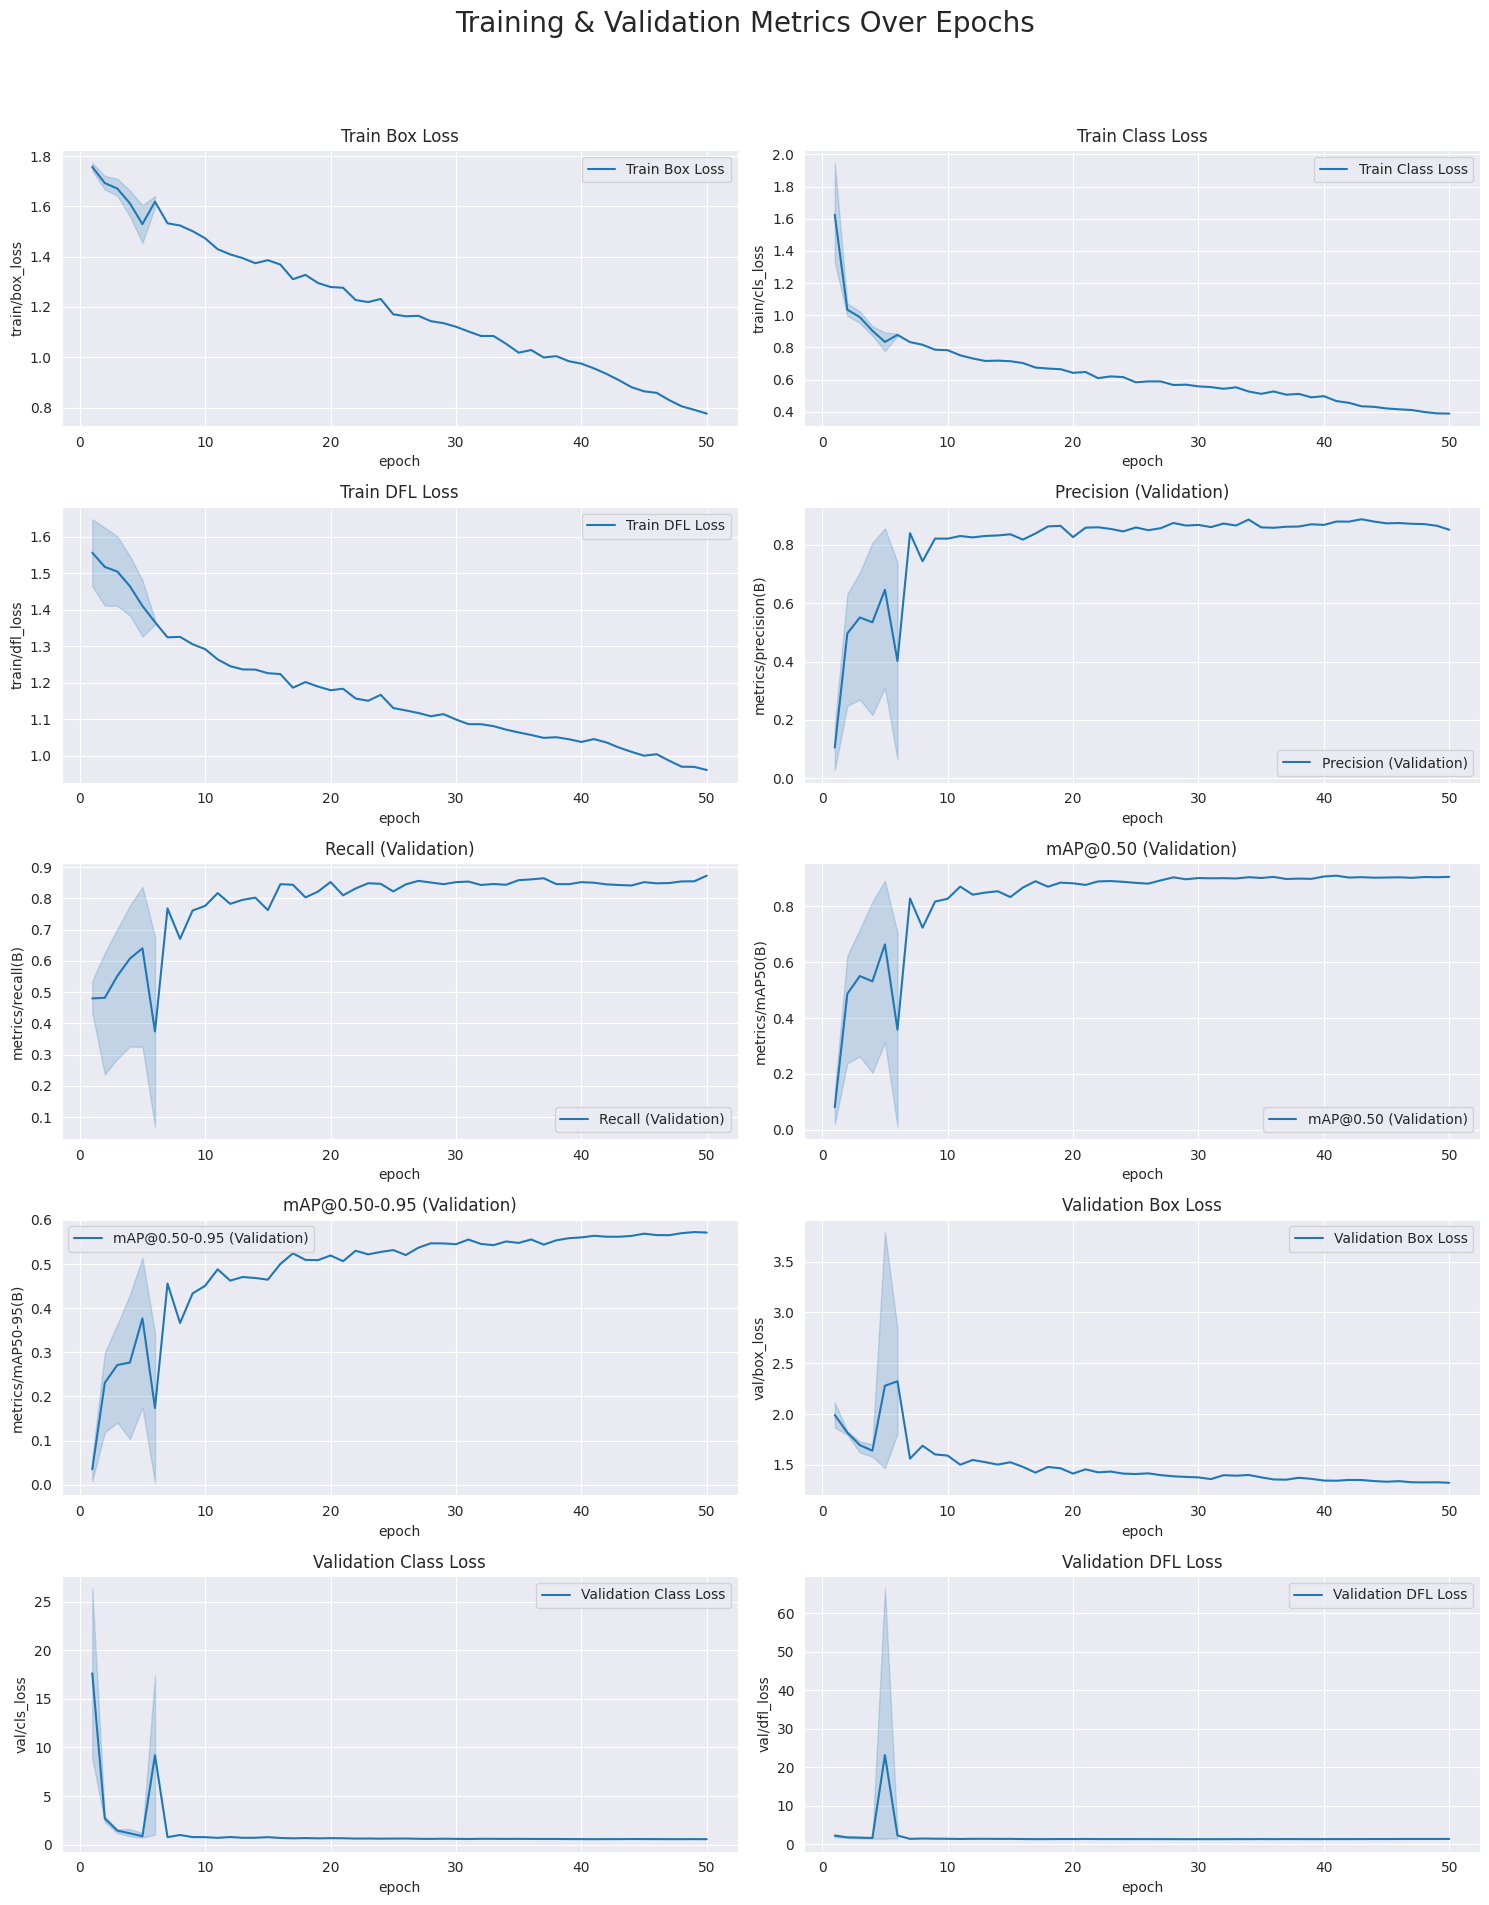

In [ ]:
# Read training log (results.csv)
if os.path.exists(RESULTS_CSV_PATH):
    df_results = pd.read_csv(RESULTS_CSV_PATH)
    df_results.columns = df_results.columns.str.strip() # Tidy column names

    # Plot losses and metrics over epochs
    # Determine the number of rows needed for subplots
    plot_definitions = [
        ('train/box_loss', 'Train Box Loss'),
        ('train/cls_loss', 'Train Class Loss'),
        ('train/dfl_loss', 'Train DFL Loss'), # Distribution Focal Loss
        ('metrics/precision(B)', 'Precision (Validation)'),
        ('metrics/recall(B)', 'Recall (Validation)'),
        ('metrics/mAP50(B)', 'mAP@0.50 (Validation)'),
        ('metrics/mAP50-95(B)', 'mAP@0.50-0.95 (Validation)'),
        ('val/box_loss', 'Validation Box Loss'),
        ('val/cls_loss', 'Validation Class Loss'),
        ('val/dfl_loss', 'Validation DFL Loss')
    ]

    num_plots = len(plot_definitions)
    num_cols = 2 # Number of columns for subplots
    num_rows = (num_plots + num_cols - 1) // num_cols # Calculate rows needed

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4)) # Adjust figsize as needed
    axs = axs.flatten() # Flatten to easily iterate

    for i, (col, title) in enumerate(plot_definitions):
        if col in df_results.columns:
            sns.lineplot(data=df_results, x='epoch', y=col, ax=axs[i], label=title).set_title(title)
            axs[i].legend()
        else:
            print(f"Warning: Column '{col}' not found in results.csv. Skipping plot for '{title}'.")
            if i < len(axs): # Hide unused subplot if column is missing
                axs[i].axis('off')


    # Hide any remaining empty subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    fig.suptitle('Training & Validation Metrics Over Epochs', fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
    plt.show()
else:
    print(f"Training results CSV not found at: {RESULTS_CSV_PATH}. Cannot plot metrics.")

## 5. Model Evaluation on Validation Set
Load the best performing weights from the training and evaluate the model on the validation dataset.

In [ ]:
# Load best-performing weights for evaluation
if os.path.exists(BEST_WEIGHTS_PATH):
    print(f"Loading best model from: {BEST_WEIGHTS_PATH}")
    model_best = YOLO(BEST_WEIGHTS_PATH)

    print("Running validation on the 'val' split with the best model...")
    validation_metrics = model_best.val(
        data=DATASET_YAML_PATH,
        conf=0.25,
        iou=0.45,
        split='val',
    )

    print("\nValidation Metrics Summary:")
    print(f"  mAP50-95 (Box): {validation_metrics.box.map:.4f}")
    print(f"  mAP50 (Box):    {validation_metrics.box.map50:.4f}")
    print(f"  mAP75 (Box):    {validation_metrics.box.map75:.4f}")
else:
    print(f"Best weights file not found at: {BEST_WEIGHTS_PATH}. Cannot perform validation.")
    validation_metrics = None

Loading best model from: /content/drive/MyDrive/Projects/Car Detection v2/Colab Env/Model History/singleclass_colab_YOLOv8/weights/best.pt
Running validation on the 'val' split with the best model...
Ultralytics 8.3.149 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 68,124,531 parameters, 0 gradients, 257.4 GFLOPs
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 68.4±13.9 MB/s, size: 64.5 KB)


val: Scanning /content/drive/MyDrive/Projects/Car Detection v2/Single Class Data/valid/labels.cache... 233 images, 14 backgrounds, 0 corrupt: 100%|██████████| 233/233 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.75it/s]


                   all        233       1686      0.846      0.882      0.901      0.609
Speed: 0.3ms preprocess, 17.8ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/val

Validation Metrics Summary:
  mAP50-95 (Box): 0.6091
  mAP50 (Box):    0.9007
  mAP75 (Box):    0.6402


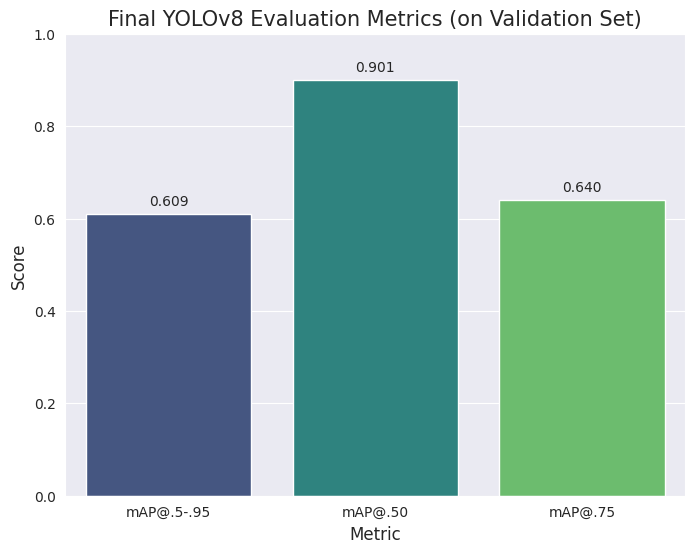

In [ ]:
# Bar chart for key mAP metrics from validation
if validation_metrics:
    map_values = [
        validation_metrics.box.map,
        validation_metrics.box.map50,
        validation_metrics.box.map75
    ]
    map_labels = ['mAP@.5-.95', 'mAP@.50', 'mAP@.75']

    plt.figure(figsize=(8, 6))
    ax_map = sns.barplot(x=map_labels, y=map_values, palette="viridis")
    ax_map.set_title('Final YOLOv8 Evaluation Metrics (on Validation Set)', fontsize=15)
    ax_map.set_ylabel('Score', fontsize=12)
    ax_map.set_xlabel('Metric', fontsize=12)
    ax_map.set_ylim(0, 1)

    # Annotate bars with their values
    for p in ax_map.patches:
        ax_map.annotate(f'{p.get_height():.3f}',
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center',
                        xytext=(0, 9),
                        textcoords='offset points', fontsize=10)
    plt.show()
else:
    print("Validation metrics not available to plot.")

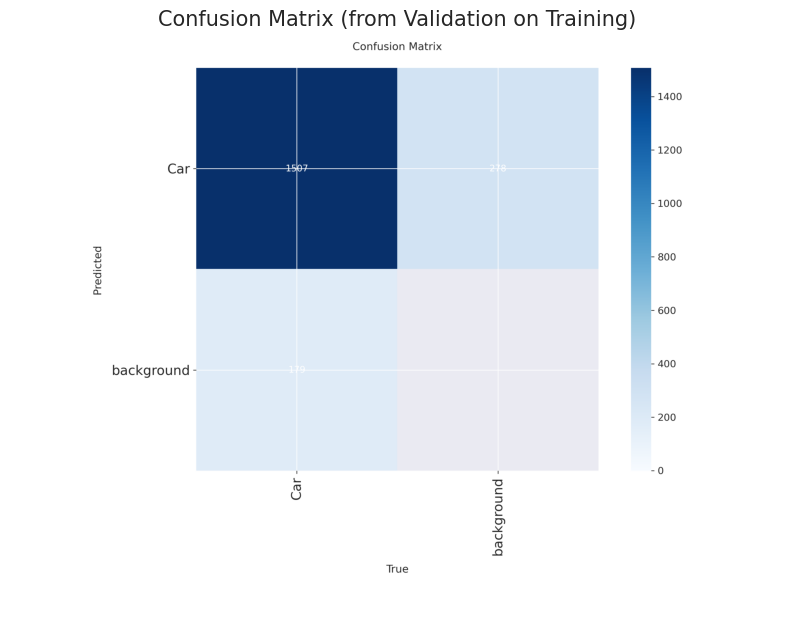

In [ ]:
if os.path.exists(CONFUSION_MATRIX_IMG_PATH):
    cm_img = mpimg.imread(CONFUSION_MATRIX_IMG_PATH)
    plt.figure(figsize=(10, 10)) # Adjust size as needed
    plt.imshow(cm_img)
    plt.axis('off') # Turn off axis numbers and ticks
    plt.title('Confusion Matrix (from Validation on Training)', fontsize=15)
    plt.show()
else:
    print(f"Confusion matrix image not found at: {CONFUSION_MATRIX_IMG_PATH}")
    print(f"Ensure that training/validation has completed and generated this file, or check the 'name' parameter in model.val() if you ran it separately.")
    print(f"Files in experiment directory ({FULL_EXPERIMENT_PATH}): {os.listdir(FULL_EXPERIMENT_PATH) if os.path.exists(FULL_EXPERIMENT_PATH) else 'Directory not found'}")

## 6. Inference on Test Images
Perform inference on new, unseen images from the test set (or any other images) using the trained model.

In [ ]:
# Inference Function
def run_inference_on_image(image_path, yolo_model, confidence_threshold=0.25, iou_threshold=0.45):
    """
    Runs YOLOv8 inference on a single image and returns the annotated RGB image.

    Args:
        image_path (str): Path to the input image.
        yolo_model (YOLO): The trained YOLO model instance.
        confidence_threshold (float): Confidence threshold for detections.
        iou_threshold (float): IoU threshold for Non-Maximum Suppression.

    Returns:
        numpy.ndarray: The image with detections plotted (in RGB format), or None if error.
    """
    if not os.path.exists(image_path):
        print(f"Error: Image not found at {image_path}")
        return None

    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print(f"Error: Could not read image {image_path}")
        return None

    # Perform inference
    results = yolo_model.predict(
        source=img_bgr, # Can be path, PIL image, numpy array
        conf=confidence_threshold,
        iou=iou_threshold,
    )
    annotated_img_bgr = results[0].plot()
    annotated_img_rgb = cv2.cvtColor(annotated_img_bgr, cv2.COLOR_BGR2RGB)

    return annotated_img_rgb

In [ ]:

if 'model_best' in locals() and model_best is not None: # Check if best model was loaded
    if os.path.exists(TEST_IMAGES_DIR) and os.listdir(TEST_IMAGES_DIR):
        test_image_files = [os.path.join(TEST_IMAGES_DIR, f) for f in os.listdir(TEST_IMAGES_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if test_image_files:
            num_test_samples_to_show = min(len(test_image_files), 16) # Show up to 16 samples
            selected_test_images = random.sample(test_image_files, num_test_samples_to_show)

            # Determine grid size
            cols = 4
            rows = (num_test_samples_to_show + cols - 1) // cols
            fig_w = 16
            fig_h = rows * 4 # Each row is 4 inches high

            _, axes_test = plt.subplots(nrows=rows, ncols=cols, figsize=(fig_w, fig_h))
            axes_test = axes_test.flatten() # Flatten to easily iterate

            for i, img_path in enumerate(selected_test_images):
                print(f"Running inference on: {img_path}")
                detected_img_output = run_inference_on_image(img_path, model_best, confidence_threshold=0.3) # Use the best model

                if detected_img_output is not None:
                    axes_test[i].imshow(detected_img_output)
                    axes_test[i].set_title(os.path.basename(img_path), fontsize=8)
                axes_test[i].axis('off')

            # Hide any unused subplots
            for j in range(i + 1, len(axes_test)):
                fig.delaxes(axes_test[j])


            plt.tight_layout()
            plt.suptitle(f'Inference on {num_test_samples_to_show} Random Test Samples', fontsize=16, y=1.02)
            plt.show()
        else:
            print(f"No image files found in the test directory: {TEST_IMAGES_DIR}")
    else:
        print(f"Test image directory not found or is empty: {TEST_IMAGES_DIR}")
else:
    print("Best model ('model_best') not loaded. Skipping inference on test images.")

Output hidden; open in https://colab.research.google.com to view.

## 7. Inference on Test Video
Perform inference on new, unseen video using the trained model.

In [ ]:
# Paths for video
in_vid  = os.path.join(VIDEO_TEST,'traffic_test.mp4')
out_vid = os.path.join(VIDEO_TEST_PREDICTION,'singleclass_colab_YOLOv8_50epochs.mp4')

cap = cv2.VideoCapture(in_vid)
fps  = int(cap.get(cv2.CAP_PROP_FPS))
w    = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h    = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Prepare output writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out    = cv2.VideoWriter(out_vid, fourcc, fps, (w, h))

frame_count = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Run detection and get annotated frame
    result = model(frame)
    det_img = result[0].plot()

    out.write(det_img)
    frame_count += 1
    if frame_count % 30 == 0:
        print(f"Processed {frame_count} frames...")

cap.release()
out.release()
print("Video processing complete. Saved to:", out_vid)

Streaming output truncated to the last 5000 lines.

0: 192x320 5 Cars, 13.3ms
Speed: 1.1ms preprocess, 13.3ms inference, 1.5ms postprocess per image at shape (1, 3, 192, 320)

0: 192x320 5 Cars, 13.7ms
Speed: 1.2ms preprocess, 13.7ms inference, 1.7ms postprocess per image at shape (1, 3, 192, 320)

0: 192x320 5 Cars, 13.0ms
Speed: 0.9ms preprocess, 13.0ms inference, 1.4ms postprocess per image at shape (1, 3, 192, 320)

0: 192x320 6 Cars, 13.7ms
Speed: 1.2ms preprocess, 13.7ms inference, 1.5ms postprocess per image at shape (1, 3, 192, 320)

0: 192x320 6 Cars, 13.8ms
Speed: 1.2ms preprocess, 13.8ms inference, 1.4ms postprocess per image at shape (1, 3, 192, 320)

0: 192x320 4 Cars, 13.6ms
Speed: 1.0ms preprocess, 13.6ms inference, 1.5ms postprocess per image at shape (1, 3, 192, 320)

0: 192x320 4 Cars, 13.7ms
Speed: 0.9ms preprocess, 13.7ms inference, 1.5ms postprocess per image at shape (1, 3, 192, 320)

0: 192x320 5 Cars, 13.3ms
Speed: 0.9ms preprocess, 13.3ms inference, 1.6ms postp